# Predicting the Sale Price of Bulldozers using Machine Learning
In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem defition
> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data
The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this project is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note**: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [5]:
# Import training and validation sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",low_memory=False)

warning - DtypeWarning: Columns (x, y) have mixed types. Specify dtype option on import or set low_memory=False.
This happens because pandas tries to infer data types in chunks to reduce memory usage. If different chunks infer different data types for the same column (e.g., strings and integers), it throws a warning.

Setting **low_memory=False** tells pandas to:

* Read the entire file first before inferring data types.
* This avoids type mismatches and the warning.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [7]:
df.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [8]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

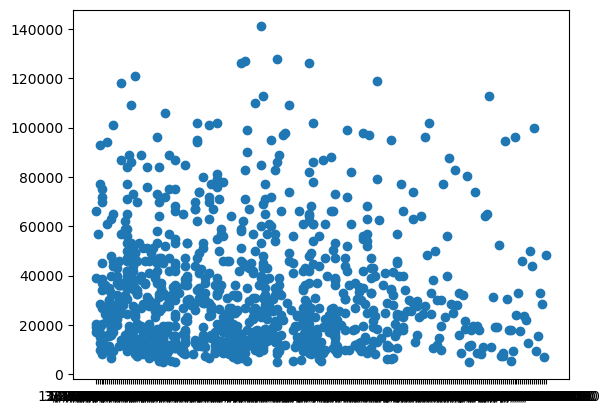

In [9]:
fig,ax = plt.subplots()
ax.scatter(df['saledate'][:1000],df['SalePrice'][:1000])

<Axes: ylabel='Frequency'>

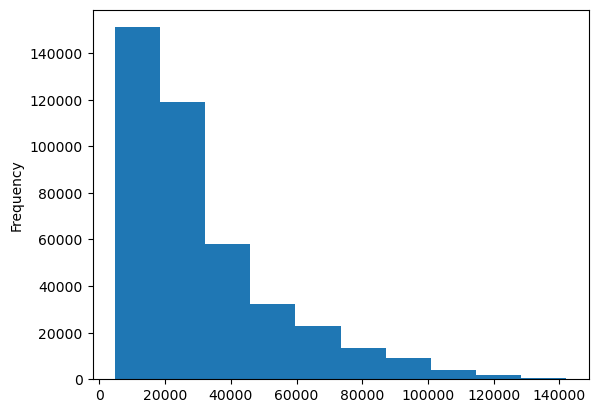

In [10]:
df.SalePrice.plot.hist()

## Parsing Dates 
Parsing dates means converting textual date/time information (e.g., "2025-07-30") into actual datetime objects (datetime64[ns] type in pandas) that pandas can understand and work with.

Raw data often stores dates as plain strings (text)

When we work with time series data, we want to enrich the time & date component as much as possible.

If we don’t parse them:

* Pandas treats them as regular strings.

* You can't filter, sort, or analyze them using time-based logic.

If we do parse them:

 You can use powerful time-based features like:

 * df['date'].dt.year, dt.month, dt.day, dt.weekday

 * Filtering: df[df['date'] > '2023-01-01']

 * Resampling: df.resample('M').mean()

 * Plotting time series properly

We can do this my telling pandas which of our columns has dates in it using the `parse_date` parameter

In [12]:
# Import data again but this time parse dates
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",low_memory=False,parse_dates=["saledate"])

In [13]:
df.saledate.dtype

dtype('<M8[ns]')

In [14]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

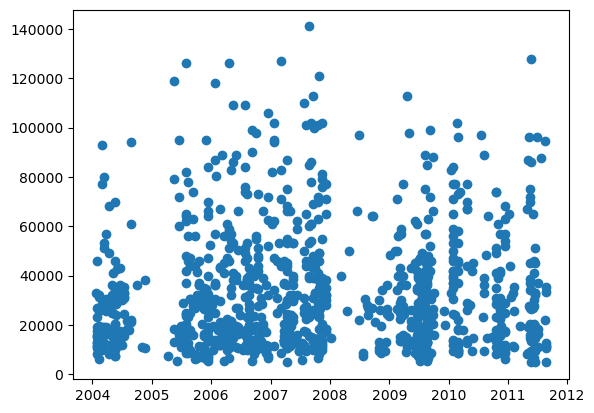

In [16]:
fig,ax = plt.subplots()
ax.scatter(df['saledate'][:1000],df['SalePrice'][:1000])

In [17]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [22]:
df.saledate.head(20)


0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [27]:
# sort DataFrame in saledate order
df.sort_values(by=['saledate'],inplace=True,ascending=True)
df.saledate.head(150)

205615   1989-01-17
67974    1989-01-31
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
            ...    
100639   1989-02-01
280033   1989-02-01
172105   1989-02-01
168665   1989-02-01
238383   1989-02-01
Name: saledate, Length: 150, dtype: datetime64[ns]

### Make a copy of the original DataFrame
We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [193]:
df_temp = df.copy()

### Add datetime parameters for `saledate` column

In [194]:
df_temp['saleYear'] = df_temp.saledate.dt.year
df_temp['saleMonth'] = df_temp.saledate.dt.month
df_temp['saleDay'] = df_temp.saledate.dt.day
df_temp['saleDayOfWeek'] = df_temp.saledate.dt.dayofweek
df_temp['saleDayOfYear'] = df_temp.saledate.dt.dayofyear

In [195]:
df_temp.head().T

,205615,67974,274835,141296,212552
SalesID,1646770,1344379,1821514,1505138,1671174
SalePrice,9500.0,70000.0,14000.0,50000.0,16000.0
MachineID,1126363,1374638,1194089,1473654,1327630
ModelID,8434,3819,10150,4139,8591
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1982,1980,1978,1980
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [196]:
# Now we've enriched our DataFrame with date time features, we can remove 'saledate'
df_temp.drop('saledate',axis=1,inplace=True)
df_temp.head().T

,205615,67974,274835,141296,212552
SalesID,1646770,1344379,1821514,1505138,1671174
SalePrice,9500.0,70000.0,14000.0,50000.0,16000.0
MachineID,1126363,1374638,1194089,1473654,1327630
ModelID,8434,3819,10150,4139,8591
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1982,1980,1978,1980
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,950B,A66,D7G,A62


In [198]:
# Check the values of different columns
df_temp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modelling
We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

In [40]:
# Build a machine learning model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

model = RandomForestRegressor(n_jobs=-1,
                             random_state=42)
model.fit(df_temp.drop("SalePrice",axis=1),df_temp["SalePrice"])

ValueError: could not convert string to float: 'Low'

In [199]:
df.info()
# not all the columndata are in numeric data type that is why we are getting the error

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [200]:
df_temp.isnull().sum()
# also there are some missing data 

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert string to categories
One way we can turn all of our data into numbers is by converting them into pandas catgories.

We can check the different datatypes compatible with pandas here: https://pandas.pydata.org/docs/reference/arrays.html

In [201]:
# Find the columns which contains strings
for label,content in df_temp.items():
    if pd.api.types.is_object_dtype(content):
        print(label)
# pd.api.types.is_string_dtype(content): only returns True for columns where every non-null value is a string and Pandas is confident the dtype is string, not just "object".
# pd.api.types.is_object_dtype(content): will include all object columns, regardless of missing values or type ambiguity.

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


**.items()**
for label, content in df.items():

It allows you to iterate over DataFrame columns where:

* label is the column name (a string),
* content is the actual column data (a Series).

In [202]:
# Changing all of the string value into category values
for label,content in df_temp.items():
    if pd.api.types.is_object_dtype(content):
        df_temp[label] = content.astype("category").cat.as_ordered()
# content.astype("category") → Converts the column to a category data type (which is memory efficient and good for non-numeric features like strings).

In [63]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 58 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   category      
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  category      
 11  fiBaseModel               412698 non-null  category      
 12  fi

In [203]:
# .cat.as_ordered() → Sets the category as ordered, which means the order of categories matters (like low < medium < high).
df_temp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [204]:
df_temp.state.cat.codes
#the numeric encoding of the state column, which has been converted to a pandas Categorical type.
# .cat.codes gives each category (state) a unique integer code.These codes range from 0 to n_categories - 1.They represent the position of each state in the .cat.categories list.

205615    43
67974      8
274835     8
141296     8
212552     8
          ..
411927     4
409783     4
409202     4
411649     4
409203     4
Length: 412698, dtype: int8

#### Handling Missing Values

In [205]:
# check missing data
df_temp.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [70]:
df_temp.isnull().sum()/len(df_temp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
saledate                    0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
T

#### Save preprocessed data

In [207]:
# Export current tmp dataframe
df_temp.to_csv("data/bluebook-for-bulldozers/train_temp_preprocessed.csv",index=False)

In [211]:
# Import preprocessed data
df_temp = pd.read_csv("data/bluebook-for-bulldozers/train_temp_preprocessed.csv",
                     low_memory=False)
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1344379,1821514,1505138,1671174
SalePrice,9500.0,70000.0,14000.0,50000.0,16000.0
MachineID,1126363,1374638,1194089,1473654,1327630
ModelID,8434,3819,10150,4139,8591
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1982,1980,1978,1980
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,950B,A66,D7G,A62


### Fill numeric missing value First

In [212]:
# Find out which all columns have numeric datatype
for label,content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [213]:
# Find out which all numeric datatype columns have missing values
for label,content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(f'{label}:{df_temp[label].isnull().sum()}')

SalesID:0
SalePrice:0
MachineID:0
ModelID:0
datasource:0
auctioneerID:20136
YearMade:0
MachineHoursCurrentMeter:265194
saleYear:0
saleMonth:0
saleDay:0
saleDayOfWeek:0
saleDayOfYear:0


In [214]:
# Fill the missing value with the median 
for label,content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            df_temp[label + "_is_missing"] = pd.isnull(content)
            #Fill the missing data with median'
            df_temp[label] = content.fillna(content.median())

In [215]:
df_temp.T

,0,1,2,3,4,5,6,7,8,9,...,412688,412689,412690,412691,412692,412693,412694,412695,412696,412697
SalesID,1646770,1344379,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,...,6282337,6311321,6306476,6281219,6324811,6313029,6286233,6283634,6311067,6283635
SalePrice,9500.0,70000.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,...,7500.0,13000.0,53000.0,39000.0,6000.0,16000.0,24000.0,35000.0,12500.0,34000.0
MachineID,1126363,1374638,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,...,1928688,1823846,1278794,1792049,1919104,1918416,1932403,1930870,1902749,1869284
ModelID,8434,3819,10150,4139,8591,4089,4123,7620,8202,2759,...,22072,17311,9114,13976,19330,17244,4605,4701,9579,4701
datasource,132,132,132,132,132,132,132,132,132,132,...,149,149,149,149,149,149,149,149,149,149
auctioneerID,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
YearMade,1974,1982,1980,1978,1980,1984,1976,1986,1970,1987,...,2005,2005,2004,2000,2004,2004,2005,1998,2003,1000
MachineHoursCurrentMeter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,950B,A66,D7G,A62,D3B,D6C,IT12,544,D5HII,...,317,S175,WA320,710VHP,2064,337G,310G,544H,S250,544H


**Why use median instead of mean to fill missing values?**

Median is more robust to outliers

Let's say you have this dataset of machine hours:[50, 60, 55, 52, 30000]

* Mean = (50 + 60 + 55 + 52 + 30000) / 5 = 6033.4
* Median = 55

Clearly, the mean is heavily skewed by the outlier 30000, while the median gives a more typical value for this data.

In [216]:
# Check again if there is any numeric values missing

for label,content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [218]:
# Check to see how many values where missing
df_temp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

We have filled missing numeric values 


#### Filling and turning categorical variables into numbers

In [219]:
# Check for columns which aren't numeric
for label,content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [220]:
# Turn categorical variables into numbers and fill missing
for label,content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_temp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_temp[label] = pd.Categorical(content).codes+1

Converts text categories into integer codes using `pd.Categorical`.

+1 is added so that:

* NaN (missing values) become 0
* Real categories start from 1
(Because pd.Categorical(...).codes gives -1 for NaN)

In [221]:
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1344379,1821514,1505138,1671174
SalePrice,9500.0,70000.0,14000.0,50000.0,16000.0
MachineID,1126363,1374638,1194089,1473654,1327630
ModelID,8434,3819,10150,4139,8591
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,True,False,True
Blade_Type_is_missing,False,True,True,False,True
Travel_Controls_is_missing,False,True,True,False,True
Differential_Type_is_missing,True,False,False,True,False


In [222]:
df_temp.isnull().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all of our data is numeric and no missing values, we should be able to build a machine learning model

In [223]:
%%time
# Instantiate the machine learning model
model = RandomForestRegressor(n_jobs=-1,
                             random_state=42)
# Fit the model
model.fit(df_temp.drop("SalePrice",axis=1),df_temp["SalePrice"])

CPU times: total: 33min 9s
Wall time: 4min 40s


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [224]:
# Score the model
model.score(df_temp.drop("SalePrice",axis=1),df_temp["SalePrice"])

0.9875954615410482

Why is this metric not reliable?

`model.score(df_temp.drop("SalePrice", axis=1), df_temp["SalePrice"])`

This line evaluates the model on the exact same data it was trained on. That means:

* The model has already seen this data.
* It may have memorized patterns or even noise.
* You're not testing its ability to generalize to new, unseen data.

#### Splitting data into train/validation sets

Train.csv is the training set, which contains data through the end of 2011.

Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012

In [225]:
df_temp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [226]:
df_temp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [227]:
# Split data into training and validation
df_val = df_temp[df_temp.saleYear== 2012]
df_train = df_temp[df_temp.saleYear !=2012]
len(df_val), len(df_train)

(11573, 401125)

In [228]:
# Split the dataset into X and y
X_train,y_train = df_train.drop('SalePrice',axis=1),df_train['SalePrice']
X_valid,y_valid = df_val.drop('SalePrice',axis=1),df_val['SalePrice']
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [128]:
y_train

205615     9500.0
67974     70000.0
274835    14000.0
141296    50000.0
212552    16000.0
           ...   
393175    27000.0
393211    10000.0
400034    11500.0
400402    36000.0
393106    28000.0
Name: SalePrice, Length: 401125, dtype: float64

### Building an evaluation function

In [230]:
# Create a evaluation function using RMSLE
from sklearn.metrics import mean_squared_log_error,mean_absolute_error,r2_score

def rmsle(y_test,y_preds):
    """
    Calculate root mean sqaured log error between predictions and true label
    """
    return np.sqrt(mean_squared_log_error(y_test,y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    scores={"Training MAE" : mean_absolute_error(y_train,train_preds),
           "Validation MAE": mean_absolute_error(y_valid,valid_preds),
           "Training RMSLE": rmsle(y_train,train_preds),
           "Validation RMSLE": rmsle(y_valid,valid_preds),
           "Training R^2":r2_score(y_train,train_preds),
           "Validation R^2":r2_score(y_valid,valid_preds)}
    return scores

### Testing our model on a subset (to tune the hyperparameters)

In [133]:
# # This takes far too long due to huge amount of dataset(400000+ rows).. for experimenting
# model = RandomForestRegressor(n_jobs=-1, 
#                               random_state=42)
# model.fit(X_train, y_train)

In [231]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000) # Use only 10,000 random samples for training each tree

In [232]:
%%time
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

CPU times: total: 1min 2s
Wall time: 9.29 s


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [233]:
show_scores(model)

{'Training MAE': 5547.376192134622,
 'Validation MAE': 7107.692941328955,
 'Training RMSLE': np.float64(0.2572097291075863),
 'Validation RMSLE': np.float64(0.2920409007251155),
 'Training R^2': 0.8611749601062739,
 'Validation R^2': 0.8346444816753742}

## Hyerparameter tuning with RandomizedSearchCV

Let's try to improve the model performance

In [234]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators" : np.arange(10,100,10),
          "max_depth": [None,3,5,10],
          "min_samples_split":np.arange(2,20,2),
          "min_samples_leaf":np.arange(1,20,2),
          "max_features":[0.5,1,"sqrt","auto"],
          "max_samples":[10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                             param_distributions=rf_grid,
                             n_iter=2,
                             cv=5,
                             verbose=True)
# Fit randomizedSearchCV model
rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 39.4 s
Wall time: 15.6 s


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [None, 3, ...], 'max_features': [0.5, 1, ...], 'max_samples': [10000], 'min_samples_leaf': array([ 1, 3..., 15, 17, 19]), ...}"
,n_iter,2
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [235]:
# Find the best model hyperparameter
rs_model.best_params_

{'n_estimators': np.int64(50),
 'min_samples_split': np.int64(8),
 'min_samples_leaf': np.int64(3),
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': 3}

In [236]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 11819.173586690087,
 'Validation MAE': 13564.409432348122,
 'Training RMSLE': np.float64(0.5068582573414449),
 'Validation RMSLE': np.float64(0.5130907955660029),
 'Training R^2': 0.48490577931242074,
 'Validation R^2': 0.4793445555907505}

### Train a model with the best hyperparamters
**Note**: These were found after 100 iterations of `RandomizedSearchCV`.

In [251]:
%%time

# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: total: 5min 2s
Wall time: 43.4 s


,n_estimators,40
,criterion,'squared_error'
,max_depth,None
,min_samples_split,14
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [238]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2947.2716371196616,
 'Validation MAE': 5940.154524668433,
 'Training RMSLE': np.float64(0.14430447492514378),
 'Validation RMSLE': np.float64(0.2454622823292531),
 'Training R^2': 0.9590980460124525,
 'Validation R^2': 0.881856539953488}

In [239]:
# Scores for rs_model (trained only on 10000 data)
show_scores(rs_model)

{'Training MAE': 11819.173586690087,
 'Validation MAE': 13564.409432348122,
 'Training RMSLE': np.float64(0.5068582573414449),
 'Validation RMSLE': np.float64(0.5130907955660029),
 'Training R^2': 0.48490577931242074,
 'Validation R^2': 0.4793445555907505}

## Make predictions on test data

In [240]:
# Import the test data from kaggle or local folder
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv",
                     low_memory=False,
                     parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [241]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...



### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [242]:
def preprocess_data(df):
    """
    Performs transformation on dataframe and returns transformed dataframe
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate",axis=1,inplace=True)
    
    
    # Fill the missing value with the median 
    
    for label,content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing
                df[label + "_is_missing"] = pd.isnull(content)
                #Fill the missing data with median'
                df[label] = content.fillna(content.median())
                
        # Filled categorical missing data and turned cateogary into numbers
        if not pd.api.types.is_numeric_dtype(content):
            # Add a binary column which tells us if the data was missing
            df[label + "_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    return df

In [243]:
# Process the test data
df_test_processed = preprocess_data(df_test)
df_test_processed.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [244]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1344379,1374638,3819,132,99.0,1982,0.0,0,1740,529,...,True,True,True,True,True,True,True,True,False,False
2,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
3,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
4,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False


In [245]:
# We can find how the columns differ using sets between train set and test set
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [260]:
# This means the test set donot have any missing data on auctioneerIDis_missing and MachineHoursCurrentMeteris_missing
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [248]:
# Finally now our test dataframe has the same features as our training dataframe, we can make predictions!

In [261]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

In [258]:
test_preds

array([18106.89665979, 17882.77599708, 46235.85495811, ...,
       11975.75351334, 18208.86647381, 23901.22021305], shape=(12457,))

In [262]:
len(test_preds)

12457

We've made some predictions but they're not in the same format Kaggle is asking for: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [263]:
# format predictions into same format kaggle is after 
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,18106.896660
1,1227844,17882.775997
2,1227847,46235.854958
3,1227848,68569.897822
4,1227863,58251.477462
...,...,...
12452,6643171,38285.267944
12453,6643173,13172.944171
12454,6643184,11975.753513
12455,6643186,18208.866474


In [264]:
# Export prediction data
df_preds.to_csv("data/bluebook-for-bulldozers/test_predictions.csv", index=False)

### Feature Importance
Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the target variable (SalePrice).

Feature importance tells you how much **each feature** (input variable) contributes to a model’s prediction.

In [266]:
# Find feature importance of our best model
ideal_model.feature_importances_
#ideal_model.feature_importances_ gives you a numeric score for each feature that indicates how important that feature was in building the trained model.

array([3.39369253e-02, 1.67578385e-02, 4.05269696e-02, 2.22276366e-03,
       3.34664349e-03, 2.06850471e-01, 3.15051292e-03, 9.64638432e-04,
       3.84329862e-02, 4.92150665e-02, 6.84654203e-02, 5.04396334e-03,
       1.46128784e-02, 1.56193086e-01, 4.87817129e-02, 5.93010577e-03,
       3.78416631e-03, 1.57046368e-03, 4.20440903e-03, 5.61141930e-02,
       9.03131301e-04, 3.98408243e-04, 8.21839928e-04, 1.97152916e-04,
       1.11255099e-03, 2.58234208e-05, 4.66202230e-05, 8.38887497e-03,
       3.04775554e-03, 1.12527057e-04, 6.36702057e-03, 1.78588090e-03,
       2.95884444e-03, 2.63342391e-03, 2.22576126e-03, 3.87969325e-03,
       7.50391320e-04, 1.80324452e-02, 3.72557587e-03, 4.91010894e-05,
       9.99969276e-04, 1.03619971e-03, 2.92757293e-03, 5.52677187e-04,
       3.63716578e-04, 3.88002096e-04, 4.89567311e-04, 2.15683787e-03,
       8.58812090e-04, 1.81714282e-04, 2.93892535e-04, 7.37547599e-02,
       3.76184231e-03, 5.63824640e-03, 2.87345517e-03, 9.89267763e-03,
      

In [269]:
# Helper function for plotting feature importance
def plot_features(columns,importances,n=20):
    df = (pd.DataFrame({"features":columns,
                       "feature_importances":importances}) # Creates a DataFrame with two columns: "features" (names) and "feature_importances" (values)
         .sort_values("feature_importances",ascending=False) # Sorts the rows by importance in descending order (most important first).
         .reset_index(drop=True))# Resets the index so it goes from 0 to N-1 after sorting. drop=True avoids keeping the old index as a new column.
    #Plot the dataframe
    fig,ax = plt.subplots()
    ax.barh(df["features"][:n],df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importances")
    ax.invert_yaxis()

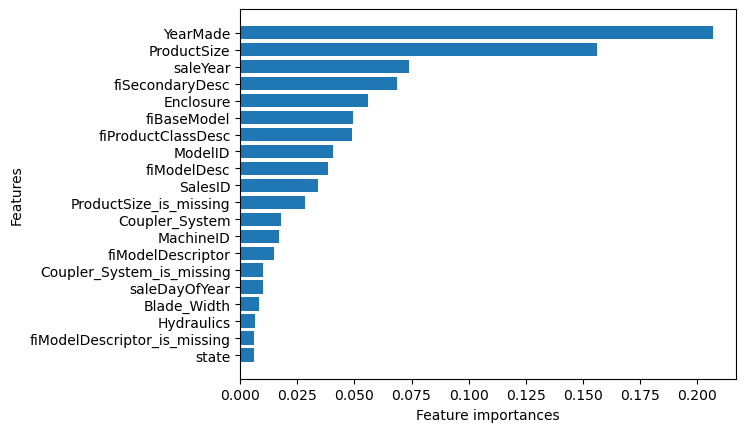

In [270]:
plot_features(X_train.columns,ideal_model.feature_importances_)